# ECG-ViEW 

In [2]:
# import libraries
import pandas as pd
import numpy as np
import pylab as plt
import imblearn
from sklearn.preprocessing import RobustScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from keras import optimizers, losses, activations, models, regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, Flatten, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from keras.utils import to_categorical
from keras.models import load_model, Sequential
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns
from collections import Counter
import random
import time

# Loading Data

In [3]:
# import train and test data into dataframes from csv files
df_cnn_train = pd.read_csv("train_noagesex.csv", header=None)
df_cnn_train = df_cnn_train.sample(frac=1)
df_cnn_test = pd.read_csv("test_noagesex.csv", header=None)

In [6]:
# get data from dataframes
y_cnn = np.array(df_cnn_train[9].values).astype(np.int8)
y_cnn=to_categorical(y_cnn)
x_cnn = np.array(df_cnn_train[list(range(9))].values)[..., np.newaxis]
y_cnn_test = np.array(df_cnn_test[11].values).astype(np.int8)
x_cnn_test = np.array(df_cnn_test[list(range(9))].values)[..., np.newaxis]

# Model Definition + Training

In [7]:
def get_model(learning_rate=0.001):
    nclass = 2
    inp = Input(shape=(9, 1))
    
    cnn = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    cnn = Dropout(rate=0.1)(cnn) 
    cnn = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(cnn)
    cnn = Dropout(rate=0.1)(cnn)
    cnn = Convolution1D(64, kernel_size=3, activation=activations.relu, padding="valid")(cnn)
    cnn = Dropout(rate=0.1)(cnn)
    cnn = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(cnn)
    cnn = GlobalMaxPool1D()(cnn)
    cnn = Dropout(rate=0.1)(cnn)
    dense_1 = Dense(64, activation=activations.relu, name="dense_1", kernel_regularizer=regularizers.l2(l=0.1))(cnn)
    dense_1 = Dense(16, activation=activations.relu, name="dense_2", kernel_regularizer=regularizers.l2(l=0.1))(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_ecg_view")(dense_1) 
    

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(learning_rate)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    return model

In [8]:
# Loading model and model summary
model = get_model()
model.summary()

# File path to save the model
file_path = "cnn_ecgview_noagesex.h5"

# Checkpointing the model's weight based on the accuracy of the model
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Set early stopping based on accuracy. It stops after 10 consecutive epochs of no accuracy improvement.
early = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1)

# Reduce learning rate based on accuracy. It reduces the rate after 7 consecutive epochs of no accuracy improvement.
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=7, verbose=2)

callbacks_list = [checkpoint, early, redonplat]

# Train the model, load weights into above file path to save the model
history = model.fit(x_cnn, y_cnn, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9, 1)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9, 16)             96        
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 32)             1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 64)             6208      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 64)             0   


Epoch 00037: val_acc improved from 0.85403 to 0.85432, saving model to baseline_cnn_ecgview_noagesex.h5
Epoch 38/1000
 - 48s - loss: 0.3816 - acc: 0.8245 - val_loss: 0.3388 - val_acc: 0.8543

Epoch 00038: val_acc did not improve from 0.85432
Epoch 39/1000
 - 47s - loss: 0.3801 - acc: 0.8257 - val_loss: 0.3382 - val_acc: 0.8556

Epoch 00039: val_acc improved from 0.85432 to 0.85562, saving model to baseline_cnn_ecgview_noagesex.h5
Epoch 40/1000
 - 47s - loss: 0.3798 - acc: 0.8258 - val_loss: 0.3401 - val_acc: 0.8536

Epoch 00040: val_acc did not improve from 0.85562
Epoch 41/1000
 - 47s - loss: 0.3808 - acc: 0.8249 - val_loss: 0.3385 - val_acc: 0.8548

Epoch 00041: val_acc did not improve from 0.85562
Epoch 42/1000
 - 47s - loss: 0.3795 - acc: 0.8262 - val_loss: 0.3398 - val_acc: 0.8553

Epoch 00042: val_acc did not improve from 0.85562
Epoch 43/1000
 - 48s - loss: 0.3781 - acc: 0.8270 - val_loss: 0.3227 - val_acc: 0.8609

Epoch 00043: val_acc improved from 0.85562 to 0.86091, saving m

# Grid Search + K Folds Cross Val

In [7]:
# def make_model(learning_rate=0.001):
#     # number of categories in our problem
#     opt = optimizers.Adam(learning_rate)
#     model = Sequential()
#     # shape of input
#     model.add (Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", input_shape=(11,1)))
#     model.add (Dropout(rate=0.1))
#     model.add (Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid"))
#     model.add (Dropout(rate=0.1))
#     model.add (Convolution1D(64, kernel_size=3, activation=activations.relu, padding="valid"))
#     model.add (Dropout(rate=0.1))
#     model.add (Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid"))
#     model.add (GlobalMaxPool1D())
#     model.add (Dropout(rate=0.1))
#     model.add (Dense(64, activation=activations.relu, name="dense_1", kernel_regularizer=regularizers.l2(l=0.1)))
#     model.add (Dense(16, activation=activations.relu, name="dense_2", kernel_regularizer=regularizers.l2(l=0.1)))
#     model.add (Dense(2, activation=activations.softmax, name="dense_3_ecg_view"))
#     model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
#     return model

In [ ]:
# # Grid Search
# from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier

# X_train = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
# X_test = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

# CNN = KerasClassifier(build_fn=get_model)
# # Grid Search to optimize the model 
# parameters = {'learning_rate':[0.001, 0.01, 0.1, 1]}
# scoring = ['roc_auc', 'accuracy', 'f1']
# clf = GridSearchCV(CNN, parameters, scoring, refit = 'roc_auc')
# grid_result = clf.fit(X_train, train_y)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [26]:
# # K Folds Cross Val
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import cross_val_score

# file_path = "baseline_cnn_ecgview.h5"

# # checkpointing the model's weight based on the accuracy of the model
# checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# # set early stopping based on accuracy improving or not. It stops after 5 epochs of no accuracy improvement
# early = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1)

# # reduces learning rate when a metric has stopped improving
# redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=7, verbose=2)

# # defining the callbacks list to include the above parameters
# callbacks_list = [checkpoint, early, redonplat]

# df = pd.read_csv('Final_Dataset.csv')
# train_data = df.values

# # Training data features
# train_features = train_data[:, 0:11]

# # 'MI' column values
# train_target = train_data[:, 11]

# # defining the scaler
# robust_scaler = RobustScaler().fit(train_data)

# # scaling test data using minmax scaling
# train_data_robust = robust_scaler.transform(train_data)

# # training data features
# train_features_robust= train_data_robust[:, 0:11]

# # 'MI' column values
# train_target_robust = train_data_robust[:, 11]


# # minority oversampling using SMOTE
# over = SMOTE(sampling_strategy=0.25) # get 25% of the data from minority
# under = RandomUnderSampler(sampling_strategy=0.5) # make majority only 50% more than the minority in final dataset
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)
# # transform the dataset
# x_re, y_re = pipeline.fit_resample(train_features_robust, train_target_robust)

# train_x, test_x, train_y, test_y = train_test_split(x_re, 
#                                                     y_re, 
#                                                     test_size=0.20, 
#                                                     random_state=0,
#                                                     shuffle=True)


# # 10-fold cross validation on the test data 
# # fix random seed for reproducibility
# seed = 7
# np.random.seed(seed)

# X_re = np.reshape(x_re, (x_re.shape[0], 1, x_re.shape[1]))

# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
# cvscores = []

# for train, test in kfold.split(X_re, y_re):
#     model = make_model(learning_rate = 0.001)
#     # Fit the model
#     model.fit(X_re[train],to_categorical(y_re[train]), epochs=1000, verbose=0, callbacks=callbacks_list, validation_split=0.1)
#     # evaluate the model
#     scores = model.evaluate(X_re[test], to_categorical(y_re[test]), verbose=0)
#     print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#     cvscores.append(scores[1] * 100)
# print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [97]:
# # checkpointing the model's weight based on the accuracy of the model
# checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# # set early stopping based on accuracy improving or not. It stops after 5 epochs of no accuracy improvement
# early = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1)

# # reduces learning rate when a metric has stopped improving
# redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=7, verbose=2)

# # defining the callbacks list to include the above parameters
# callbacks_list = [checkpoint, early, redonplat]

# Model Evaluation + Training Plots

In [9]:
start_time = time.time()


y_pred = model.predict(x_cnn_test)
y_pred = np.argmax(y_pred, axis=-1)

print("--- inference time of %s seconds ---" % (time.time() - start_time))

# Get F1 score
f1 = f1_score(y_cnn_test, y_pred, average="macro")
print("Test f1 score : %s "% f1)

# Get ROC AUC
roc = roc_auc_score(y_cnn_test, y_pred)
print("Test ROC AUC score : %s "% roc)

# Get the accuracy 
acc = accuracy_score(y_cnn_test, y_pred)
print("Test accuracy score : %s "% acc)

# Get the specificity
tn, fp, fn, tp = confusion_matrix(y_cnn_test, y_pred).ravel()
specificity = tn / (tn+fp)
print("Specificity : %s "% specificity)

# Get the sensitivity
sensitivity= tp / (tp+fn)
print("Sensitivity: %s "% sensitivity)

--- inference time of 3.603668212890625 seconds ---
Test f1 score : 0.8559013975121876 
Test ROC AUC score : 0.8650519295421595 
Test accuracy score : 0.8689460844569677 
Specificity : 0.8766989328080046 
Sensitivity: 0.8534049262763147 


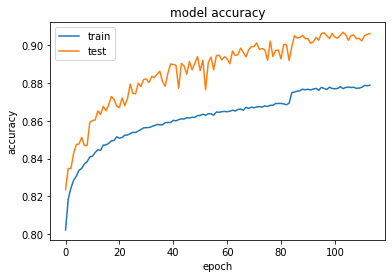

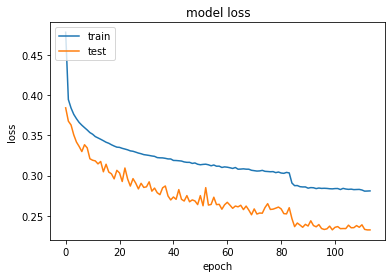

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


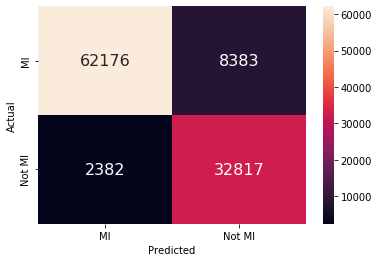

In [9]:
# Confusion matrix
confusion = confusion_matrix(y_cnn_test, pred_test)
sns.heatmap(data=confusion, annot=True, xticklabels=["MI", "Not MI"], yticklabels=["MI", "Not MI"], fmt = "d", annot_kws={"fontsize":16})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.yticks(va="center")
plt.show()